# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader

from bnaf.toy2d import main as bnaf
from bnaf.toy2d import compute_log_p_x
import torch
    
reproducibility.clear_cache()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['sdv_ctgan',
 'bayesian_network',
 'gaussian_copula',
 'sdv_tvae',
 'dpgan',
 'copulagan',
 'tvae',
 'adsgan',
 'rtvae',
 'privbayes',
 'ctgan',
 'nflow',
 'pategan']

# Load data and settings

In [2]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from bnaf.data.generate2d import sample2d

dataset = 'gaussian'
p_train = 0.5
nsyn = 5000

if dataset=='diabetes':
    X, y = load_diabetes(return_X_y=True, as_frame=True)
elif dataset=='iris':
    X, y = load_iris(return_X_y=True, as_frame=True)
elif dataset=='boston':
    X, y = load_boston(return_X_y=True, as_frame=True)
elif dataset=='breast_cancer':
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
elif dataset=='wine':
    X, y = load_wine(return_X_y=True, as_frame=True)
elif dataset=='digits':
    X, y = load_digits(return_X_y=True, as_frame=True)
elif dataset=='moons':
    X, y = make_moons(n_samples=10000, noise=0.2, random_state=0)
    X = pd.DataFrame(X)
    p_train = 0.2
elif dataset in ["8gaussians", "2spirals", "checkerboard", "t1", "t2", "t3", "t4"]:
    X = sample2d(dataset, 20000)
    X = pd.DataFrame(X)
    y = -np.ones(X.shape[0])
    p_train = 0.5
    nsyn = 20000
elif dataset=='gaussian':
    n_real = 10000
    X = np.random.randn(n_real,2)
    X = pd.DataFrame(X)
    noise = 2
    y = X[0] > noise*(np.random.uniform(size=n_real)-1/2)
    p_train = 0.05
elif dataset=='uniform':
    n_real = 10000
    X = np.random.uniform(size=(n_real,2))
    X = pd.DataFrame(X)
    y = X[0] > np.random.uniform(size=n_real)
    p_train = 0.1
else:
    raise ValueError('Unknown dataset')

X["target"] = y
X_gt = GenericDataLoader(X, target_column="target", train_size=p_train)

if len(np.unique(y))==1:
    X_gt.targettype = None
elif len(np.unique(y))<=10:
    X_gt.targettype = 'classification'
else:
    X_gt.targettype = 'regression'

X_train, X_test = X_gt.train(), X_gt.test()


n_train = X_train.shape[0]
model_name = 'tvae'
results_folder = "uncertainty_results/"+dataset+"/"+model_name
workspace_folder = "workspace/"+dataset+"/"+model_name
n_models = 20
load = True
load_syn = True
save = True
print(n_train)




500


# Generate data

In [3]:

for i in range(n_models):
    os.makedirs(results_folder, exist_ok=True)
    filename = f"{results_folder}/Xsyn_n{n_train}_seed{i}.pkl"
    # filename2 = f"{results_folder}/X_syn_{i}.pkl"
    # if os.path.exists(filename2):
    #     os.rename(filename2, filename)    
    if os.path.exists(filename) and load_syn:
        continue
    print(f"Training model {i+1}/{n_models}")

    reproducibility.enable_reproducible_results(seed=i)
    syn_model = Plugins().get(model_name)
    syn_model.fit(X_train)
    X_syn = syn_model.generate(count = nsyn)
    # save X_syn to disk as pickle
    pickle.dump(X_syn, open(filename, "wb"))
    # save model to disk as pickle
    # filename = f"{results_folder}/{model_name}_n{n_train}_seed{i}.pkl"
    # pickle.dump(syn_model, open(filename, "wb"))
    





# Load data

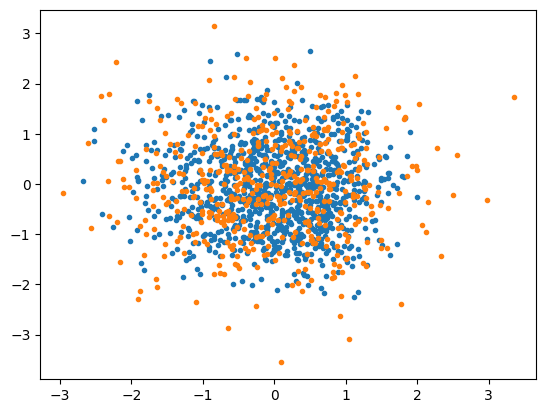

In [4]:
X_syns = []
for i in range(n_models):
    # load X_syn from disk as pickle
    X_syn = pickle.load(open(f"{results_folder}/Xsyn_n{n_train}_seed{i}.pkl", "rb"))
    X_syns.append(X_syn)

# plot what we generated
X_syn_all = np.concatenate([X_syns[i].unpack(as_numpy=True)[0] for i in range(len(X_syns))])
a = X_syn_all[np.random.choice(X_syn_all.shape[0], 1000, replace=False)]
plt.scatter(a[:,0], a[:,1], marker='.')
b = X_gt.train().unpack(as_numpy=True)[0]
plt.scatter(b[:,0], b[:,1], marker='.')

# Analyses
## Some function definitions

In [5]:

def prediction_task(X_gt, X_syn, model=None, model_type='mlp'):
    if type(model)==str or model is None:
        if model_type=='mlp' or model is None:
            if X_gt.targettype == 'classification':
                model = sklearn.neural_network.MLPClassifier()
            else:
                model = sklearn.neural_network.MLPRegressor()
        elif model_type=='rf':
            if X_gt.targettype == 'classification':
                model = sklearn.ensemble.RandomForestClassifier()
            else:
                model = sklearn.ensemble.RandomForestRegressor()
        elif model_type=='knn':
            if X_gt.targettype == 'classification':
                model = sklearn.neighbors.KNeighborsClassifier()
            else:
                model = sklearn.neighbors.KNeighborsRegressor()
        elif model_type=='svm':
            if X_gt.targettype == 'classification':
                model = sklearn.svm.SVC()
            else:
                model = sklearn.svm.SVR()
        elif model_type=='xgboost':
            pass
        X, y = X_syn.unpack(as_numpy=True)
        model.fit(X, y.reshape(-1,1))
    pred = model.predict(X_gt.unpack(as_numpy=True)[0])
    return pred, model


def meanstd(A):
    return np.mean(A, axis=0), np.std(A, axis=0)


def density_estimation(X_gt, X_syn, model=None, model_type = 'kde'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    from scipy.stats import gaussian_kde
    if model_type == 'bnaf':
        print('Training BNAF')
        if model is None:
            model = bnaf(X_syn.unpack(as_numpy=True)[0])
        X = torch.utils.data.TensorDataset(torch.tensor(X_gt.unpack(as_numpy=True)[0], device=device).to(torch.float32))
        X = torch.utils.data.DataLoader(X, batch_size=10000, shuffle=False)
        prob = torch.cat(
            [
                torch.exp(compute_log_p_x(model, x_mb)).detach()
                for x_mb, in X
            ],
            0,
        )
        return torch.exp(prob).detach().cpu().numpy(), model
    elif model_type=='kde':
        print('Training KDE')
        if model is None:
            model = gaussian_kde(X_syn.unpack(as_numpy=True)[0].T)
        return model.pdf(X_gt.unpack(as_numpy=True)[0].T), model



def aggregate(X_gt, X_syns, task, models=None, task_type = '', load=True, save=True, filename=''):
    results = []
    trained_models = []
    fileroot = f'{workspace_folder}/{task.__name__}_{task_type}'
    if not os.path.exists(fileroot) and save:
        os.makedirs(fileroot)
    
    for i in range(len(X_syns)):
        print(f'Train model {i+1}/{len(X_syns)}')
        if models is None:
            print(f'{fileroot}_{filename}{i}.pkl')
            if os.path.exists(f'{fileroot}_{filename}{i}.pkl') and load:
                model = pickle.load(open(f"{fileroot}_{filename}{i}.pkl", "rb"))
            else:
                model = None
        else:
            model = models[i]
        reproducibility.enable_reproducible_results(seed=i+2022)
        res, model = task(X_gt, X_syns[i], model, task_type)
        results.append(res)
        trained_models.append(model)
        # save model to disk as pickle
        if models is None and save:
            pickle.dump(model, open(f"{fileroot}_{filename}{i}.pkl", "wb"))
    
    return *meanstd(results), trained_models

def tsne(X):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    return X_2d

def aggregate_imshow(X_gt, X_syns, task, models=None, task_type = '', load = True, save=True, filename=''):
    xmin, ymin = np.min(X_gt.unpack(as_numpy=True)[0], axis=0)*1.5
    xmax, ymax = np.max(X_gt.unpack(as_numpy=True)[0], axis=0)*1.5
    
    steps = 400
    X_grid = np.linspace(xmin, xmax, steps)
    Y_grid = np.linspace(ymin, ymax, steps)

    X_grid, Y_grid = np.meshgrid(X_grid, Y_grid)
    X_grid = pd.DataFrame(np.c_[X_grid.ravel(), Y_grid.ravel()])
    X_grid['target'] = -1
    X_grid = GenericDataLoader(X_grid, target_column="target", train_size=0.01)
    X_grid.targettype = X_gt.targettype

    y_pred_mean, y_pred_std, models = aggregate(X_grid, X_syns, task, models, task_type, load, save, f'n{len(X_gt.train().unpack()[0])}_{filename}')

    for y, stat in zip((y_pred_mean, y_pred_std), ('mean', 'std')):
        plt.figure(figsize=(8,6), dpi=100)
        plt.imshow(y.reshape(steps,steps)[::-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax])
        plt.colorbar()
        if dataset == 'gaussian':
            plt.vlines(0, ymin, ymax, colors='r', linestyles='dashed')
        plt.savefig(f'{results_folder}/{task.__name__}_n{len(X_gt.train().unpack()[0])}_{filename}{stat}.png')
        plt.show()
        X_train, y_train = X_gt.train().unpack(as_numpy=True)
        if len(np.unique(y_train))==2:
            plt.imshow(y.reshape(steps,steps)[::-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax])
            y_train = y_train.astype(bool)        
            plt.scatter(X_train[y_train,0], X_train[y_train,1], c='k', marker='.')
            plt.scatter(X_train[~y_train,0], X_train[~y_train,1], c='w', marker='.')
            plt.colorbar()
            if dataset == 'gaussian':
                plt.vlines(0, ymin, ymax, colors='r', linestyles='dashed')
            plt.savefig(f'{results_folder}/{task.__name__}_n{len(X_gt.train().unpack()[0])}_{filename}{stat}_with_samples.png')
            plt.show()

    return y_pred_mean, y_pred_std, models



## Predictions across models

## Generative uncertainty

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_10.pkl
Train model 12/20
workspace/gaussian/tvae/prediction_task_mlp_n500_11.pkl
Train model 13/20
workspace/gaussian/tvae/prediction_task_mlp_n500_12.pkl
Train model 14/20
workspace/gaussian/tvae/prediction_task

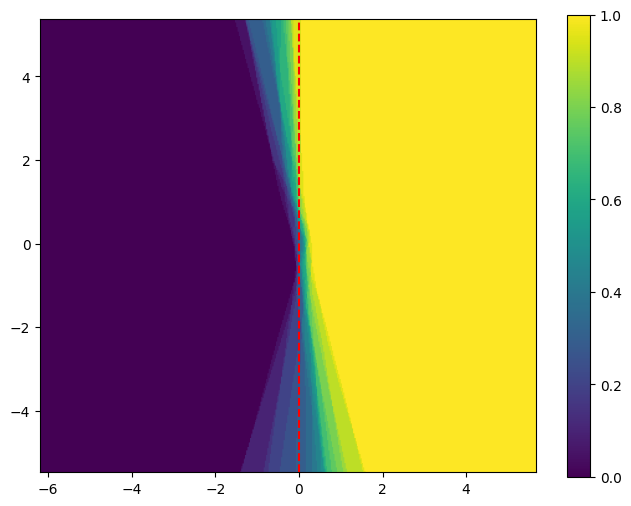

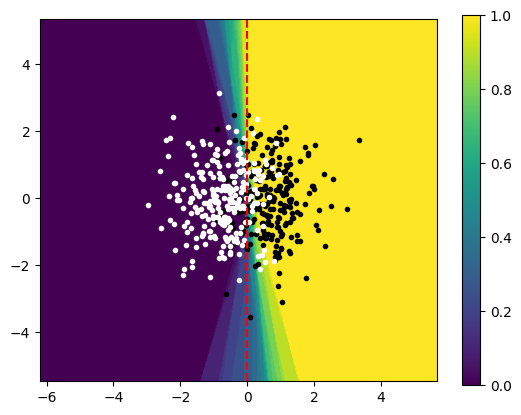

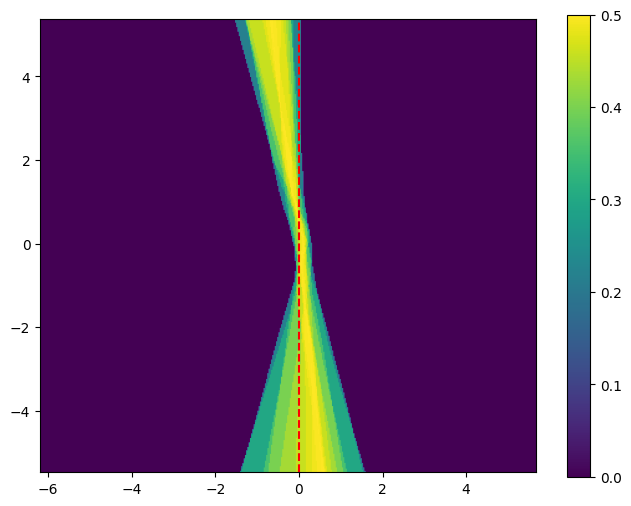

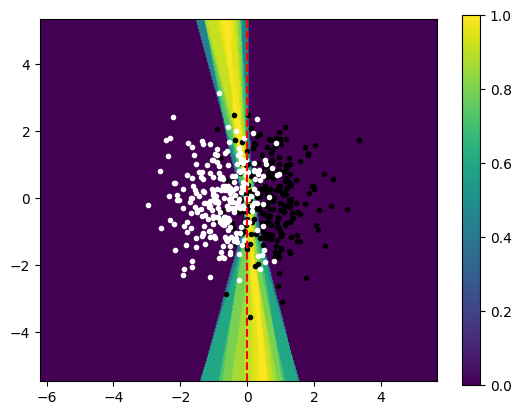

In [6]:
if X_gt.targettype is not None:
    y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syns, prediction_task, models=None, task_type='mlp', load=load, save=save)

    # print('Predictions on test set:')
    # X, y = X_gt.test().unpack(as_numpy=True)
    # if X.shape[1]>2:
    #     Xplot = tsne(X)
    # else:
    #     Xplot = X
    # for y in [y_pred_mean, y_pred_std]:
    #     plt.scatter(Xplot[:,0], Xplot[:,1], c=y, cmap='viridis')
    #     plt.colorbar()
    #     plt.show()
    
    # print('Predictions on full space:')
    # aggregate_imshow(X_gt, X_syns, prediction_task, models)


## Single model

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single10.pkl
Train model 12/20
workspace/gaussian/tvae/prediction_task_mlp_n500_single11.pkl
Train model 13/20
workspace/gaussian/tvae/prediction_task_m

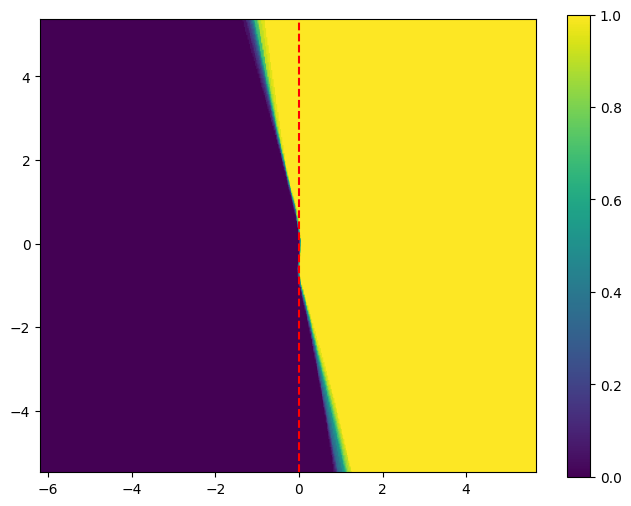

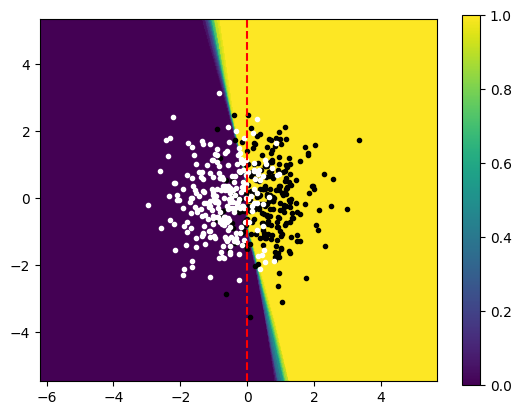

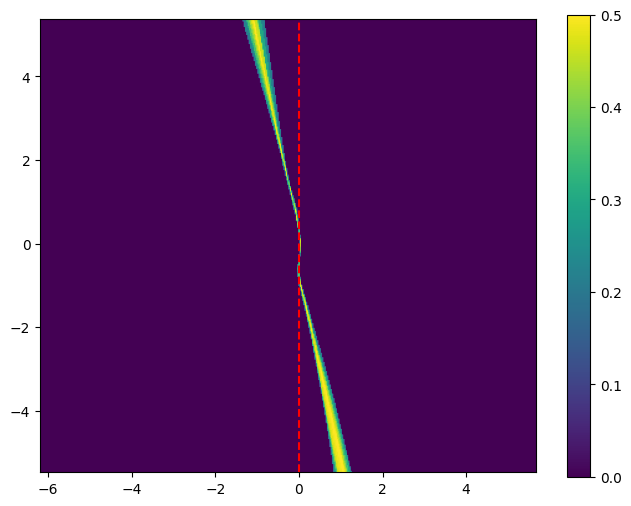

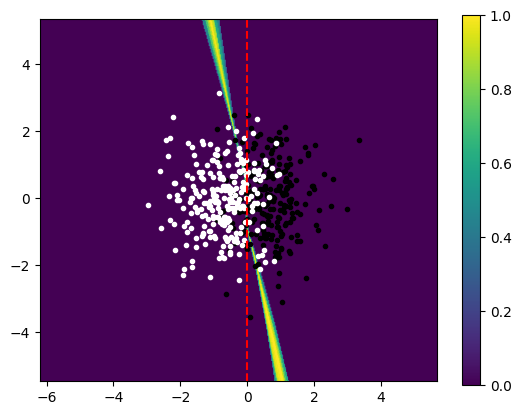

In [7]:
if X_gt.targettype is not None:
    X_syn_0 = [X_syns[0] for _ in range(len(X_syns))]
    y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syn_0, prediction_task, models=None, task_type='mlp', load=load, save=save, filename='single')


## Data aggregated

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate10.pkl
Train model 12/20
workspace/gaussian/tvae/prediction_task_mlp_n500_aggregate11.pkl
Train model 13/20
works

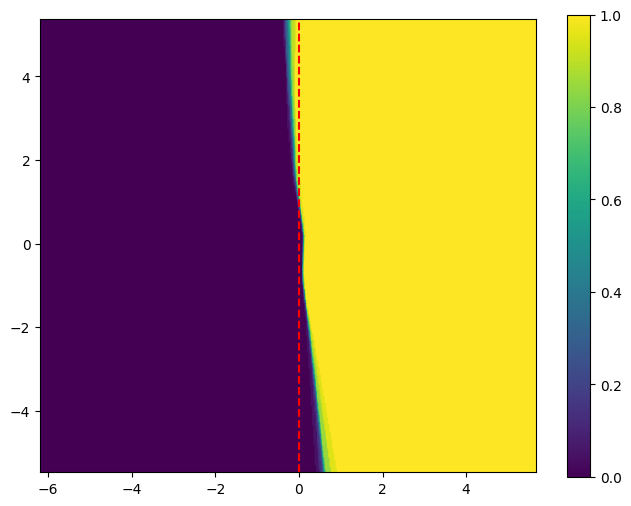

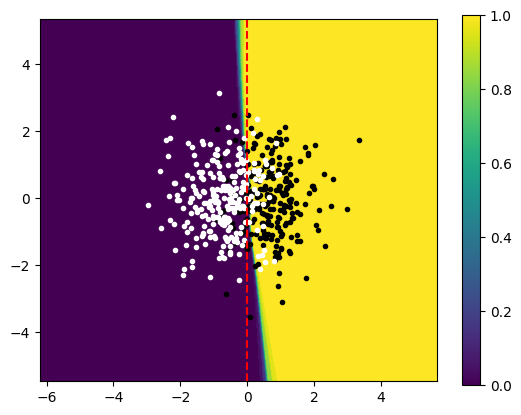

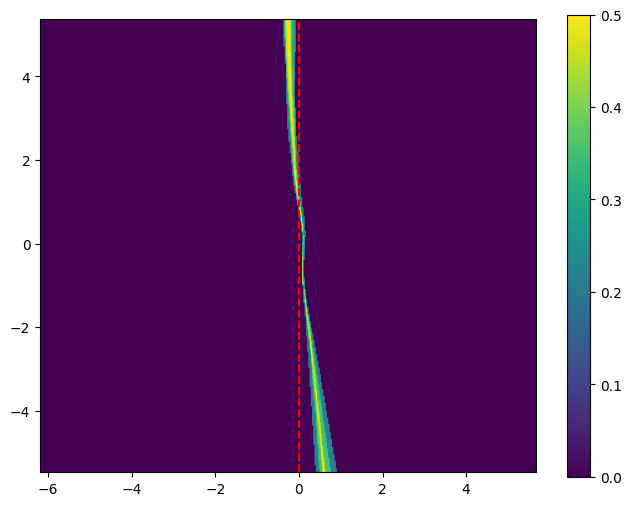

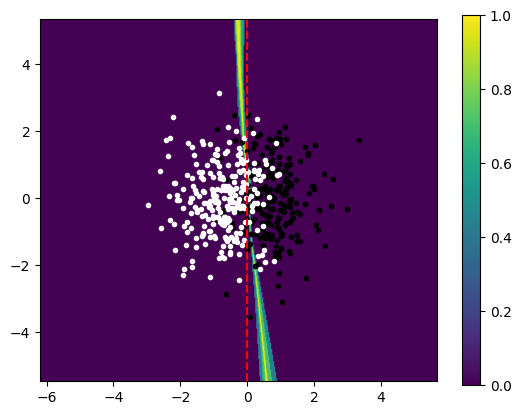

In [8]:
if X_gt.targettype is not None:
    X_syn_cat = pd.concat([X_syns[i].dataframe() for i in range(len(X_syns))],axis=0)
    X_syn_cat = GenericDataLoader(X_syn_cat, target_column="target")
    X_syn_cat = [X_syn_cat for _ in range(len(X_syns))]
    #X_syn_cat = [X_syn_cat.sample(len(X_syns[0])) for _ in range(len(X_syns))]
    
    y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syn_cat, prediction_task, models=None, task_type='mlp', load=load, save=save, filename='aggregate')

## Density estimation
We ignore the target and regard density estimation as the downstream task. We use the flow-based BNAF from Cao as DE method.

In [9]:
if X_gt.targettype is None:
    X_test = X_gt.test()
    X_test.targettype = X_gt.targettype
    y_pred_mean, y_pred_std, models = aggregate_imshow(X_test, X_syns, density_estimation, models=None, task_type='kde', load=load, save=save)
    



# Influence of synthetic data size

Let's study the effect of synthetic data size. Let us first look at the generative estimates

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_gende10.pkl
Train model 12/20
workspace/gaussian/tvae/prediction_task_mlp_

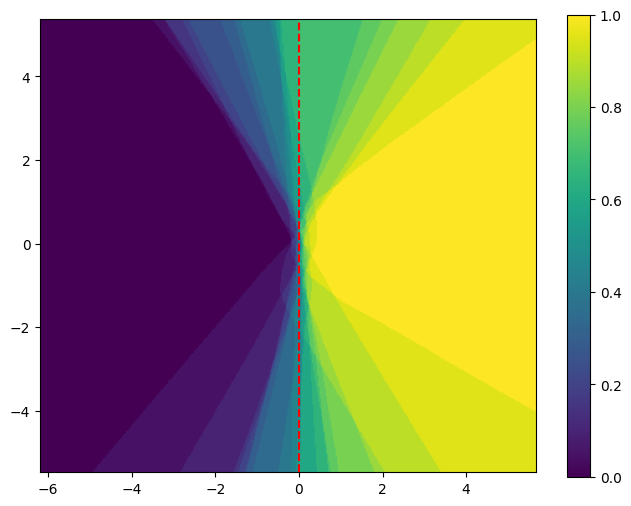

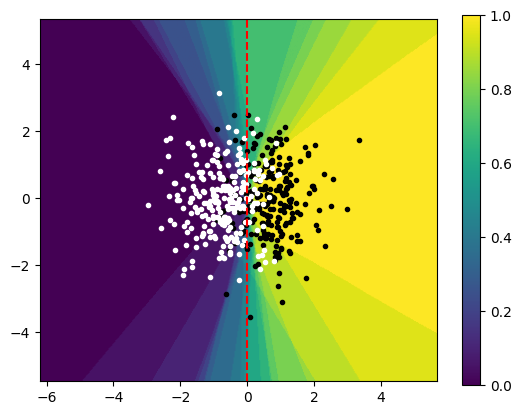

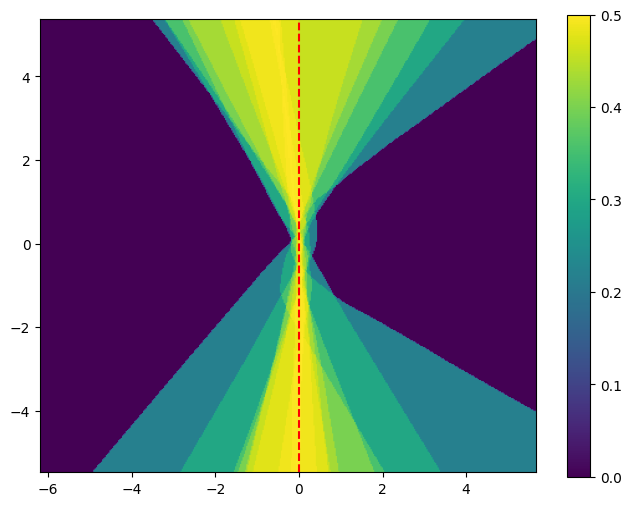

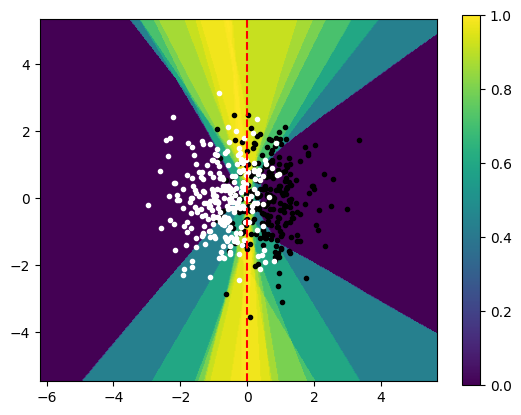

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_gende10.pkl
Train model 12/20
workspace/gaussian/tvae/predictio

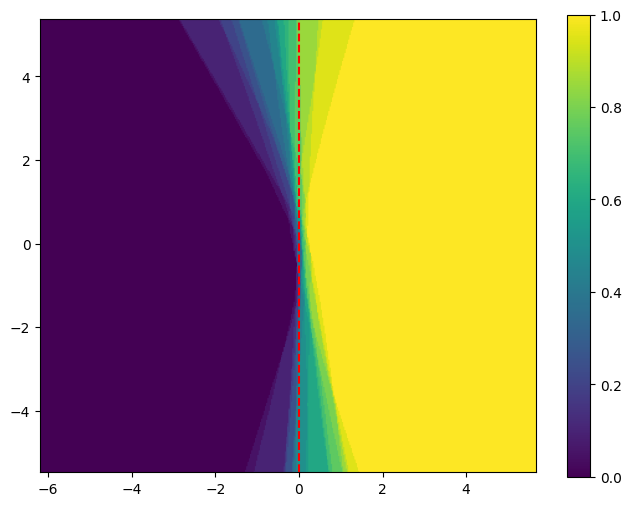

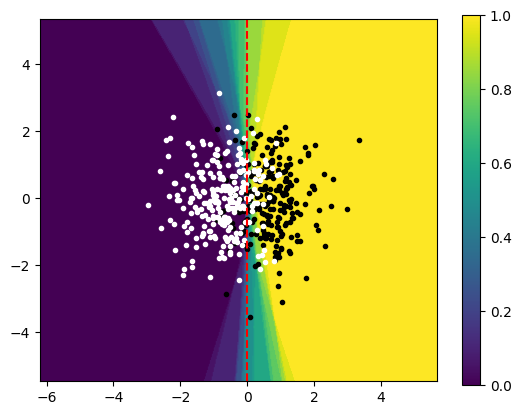

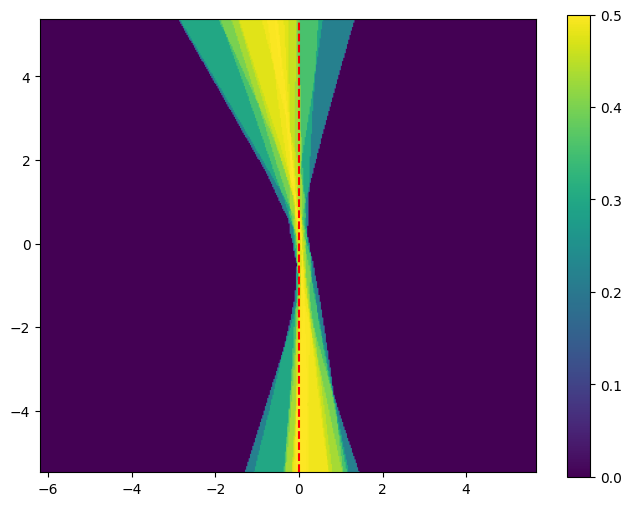

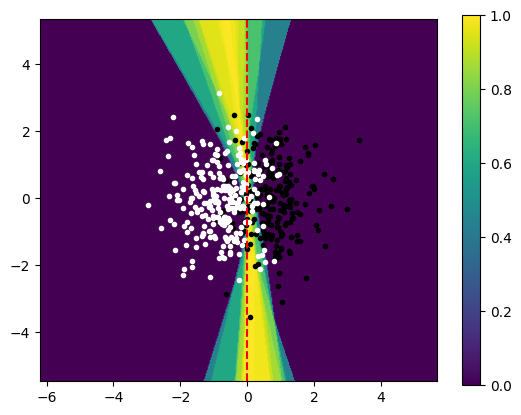

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_gende10.pkl
Train model 12/20
workspace/gaussian/tva

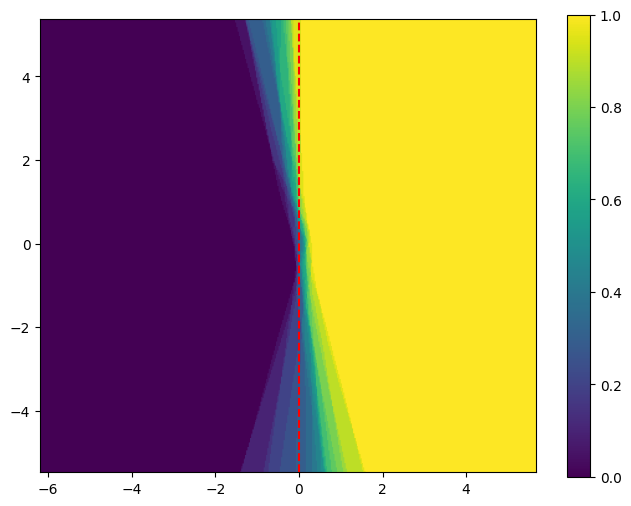

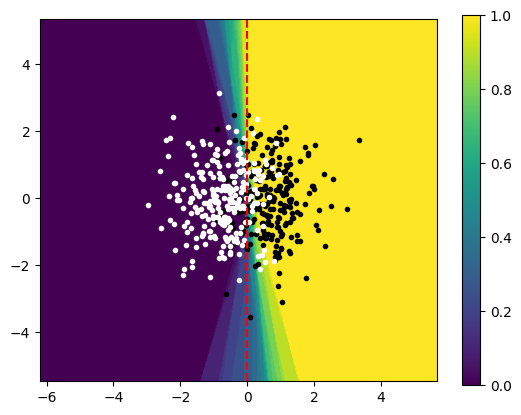

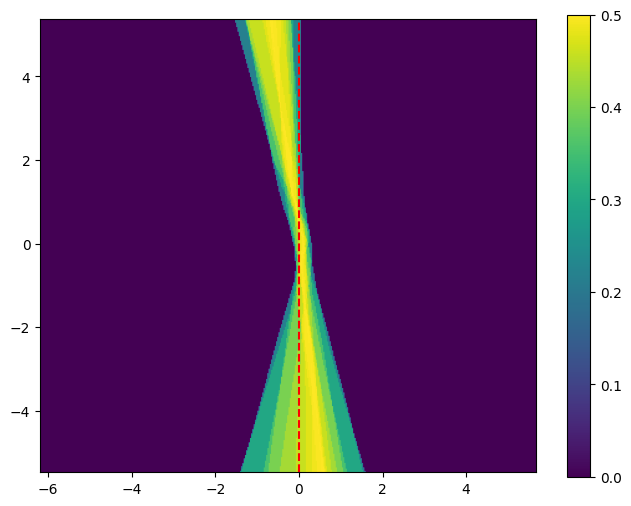

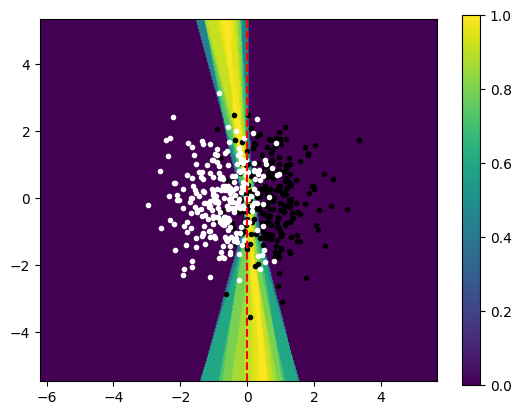

In [19]:
n_syns = [nsyn//100, nsyn//10, nsyn]
if X_gt.targettype=='classification':    
    for n_syn in n_syns: 
        X_syns_red = [GenericDataLoader(X_syns[i][:n_syn], target_column='target') for i in range(len(X_syns))]
        y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syns_red, prediction_task, models=None, task_type='mlp', load=load, save=save, filename=f'n_syn{n_syn}_gende')



Now let's look at the same behaviour by a single data and a downstream DE

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_single10.pkl
Train model 12/20
workspace/gaussian/tvae/predictio

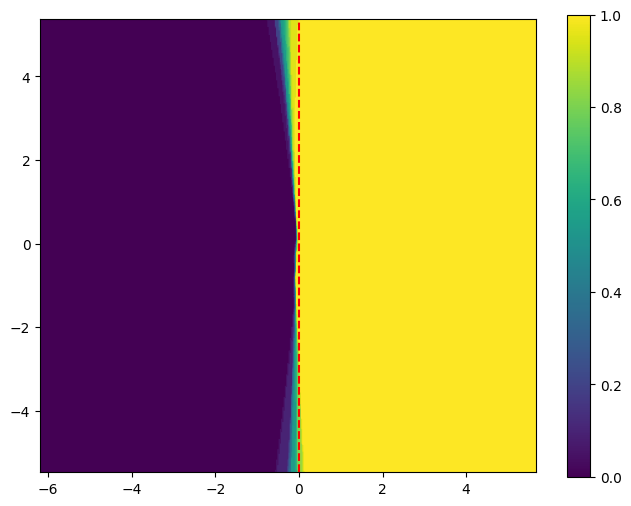

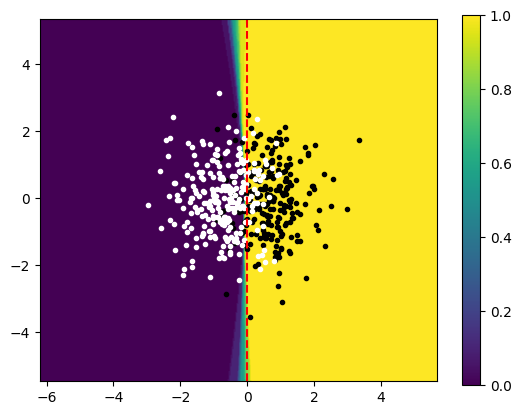

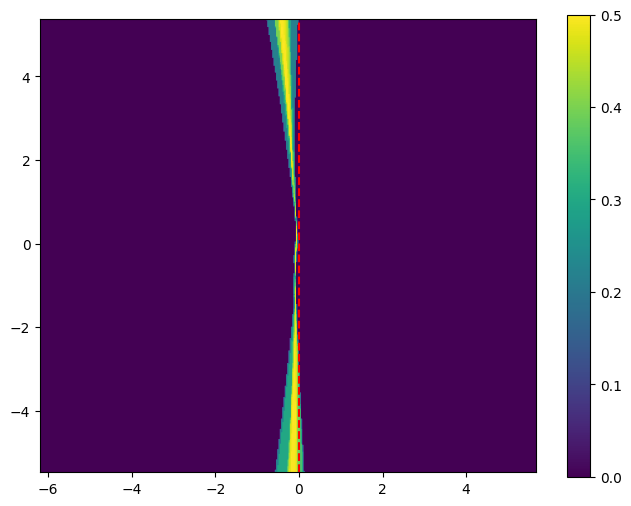

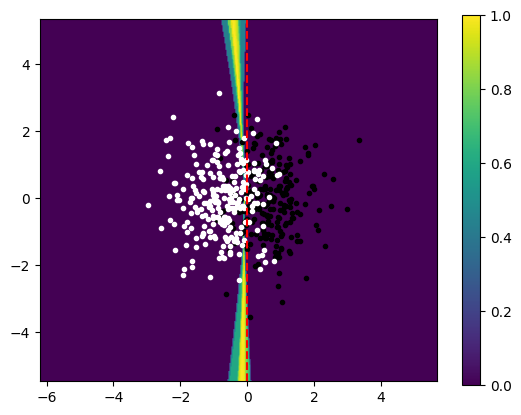

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_single10.pkl
Train model 12/20
workspace/gaussian/tva

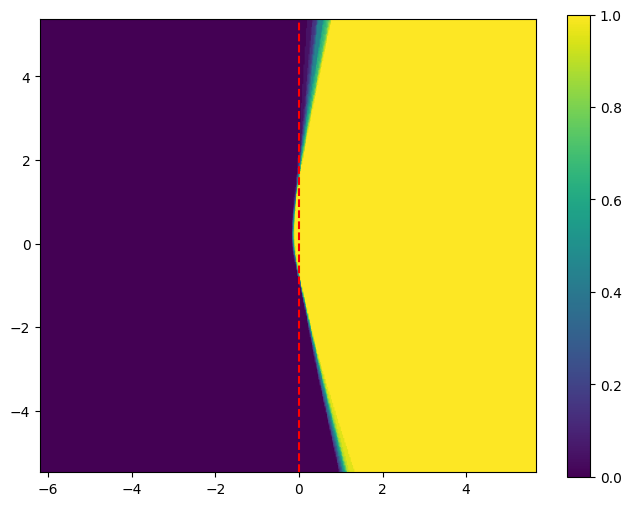

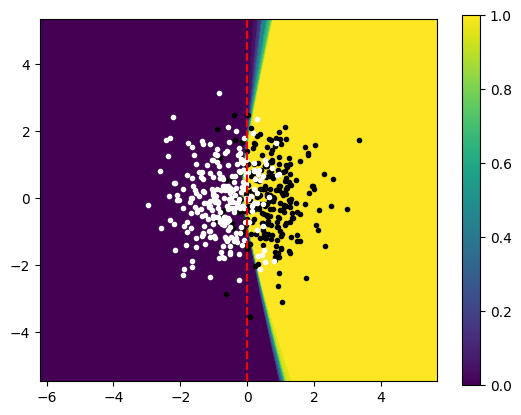

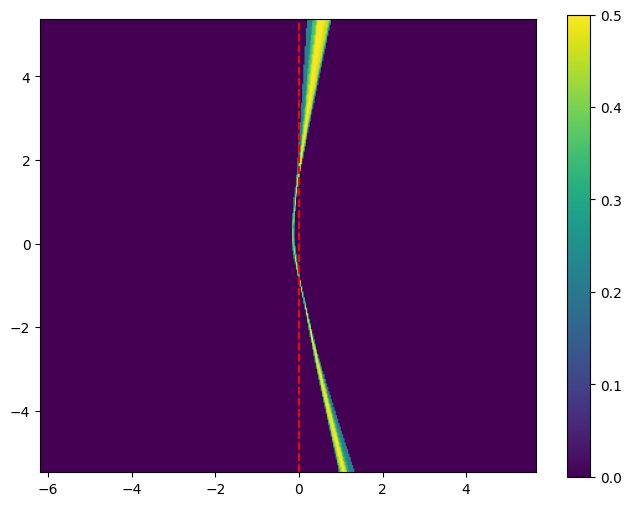

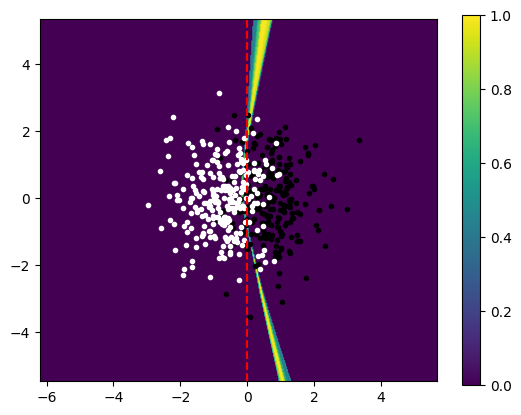

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_single10.pkl
Train model 12/20
workspace/g

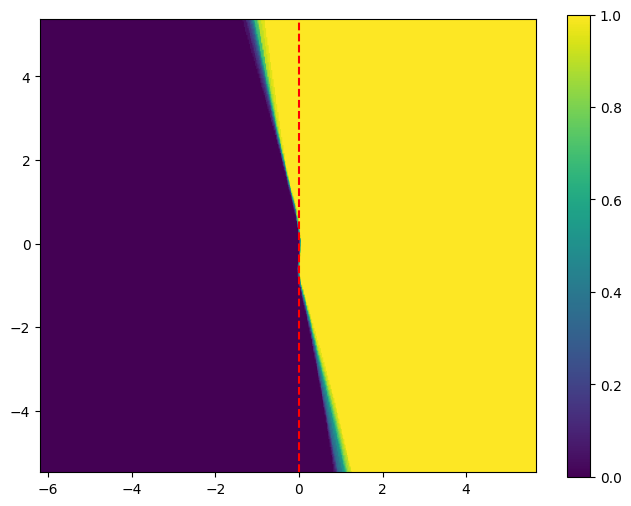

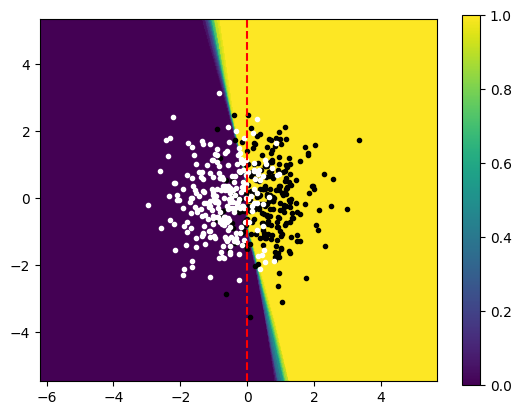

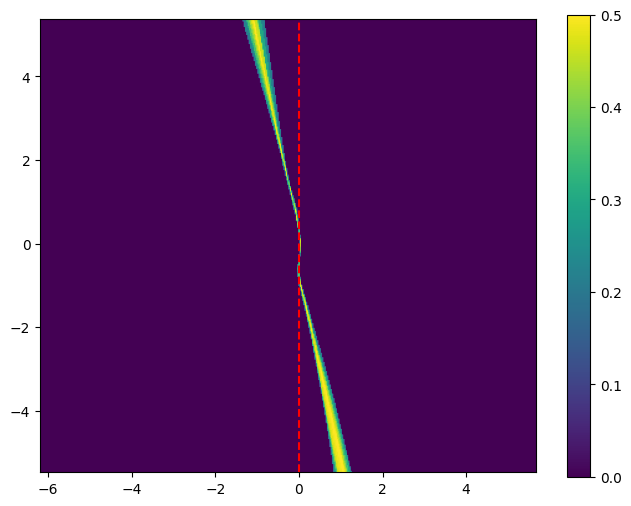

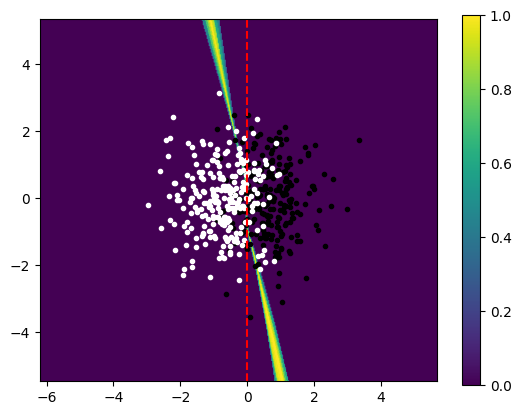

In [20]:
if X_gt.targettype=='classification':    
    for n_syn in n_syns:
        X_syn_0 = [GenericDataLoader(X_syns[0][:n_syn], target_column='target') for i in range(len(X_syns))]
        y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syn_0, prediction_task, models=None, task_type='mlp', load=load, save=save, filename=f'n_syn{n_syn}_single')



And what happens when using all data for the downstream DE?

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn50_aggregate10.pkl
Train model 12/20


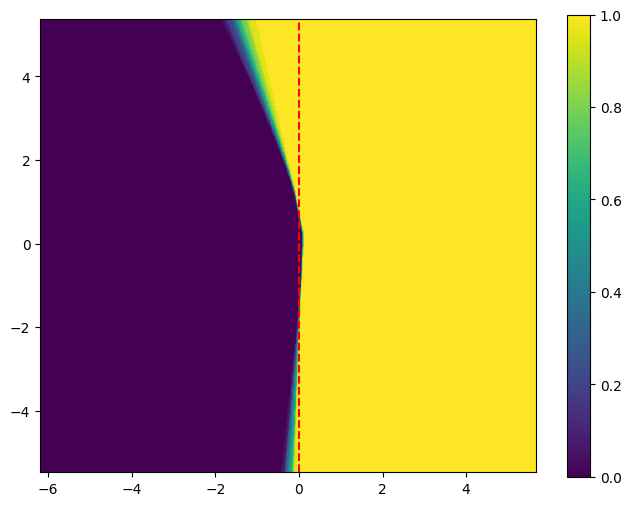

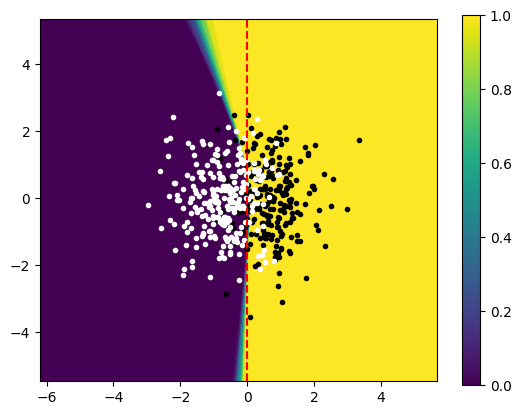

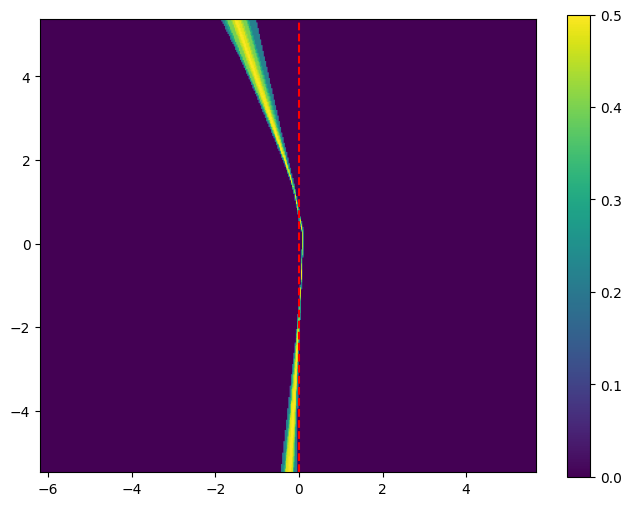

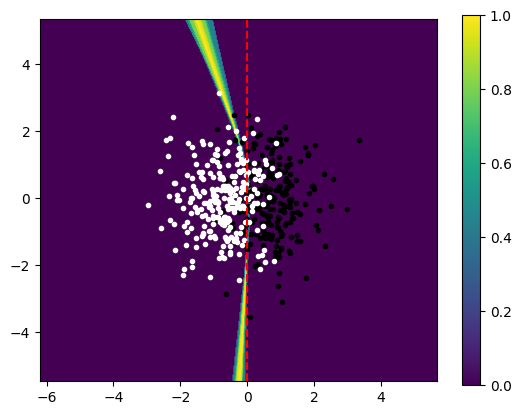

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn500_aggregate10.pkl
Train m

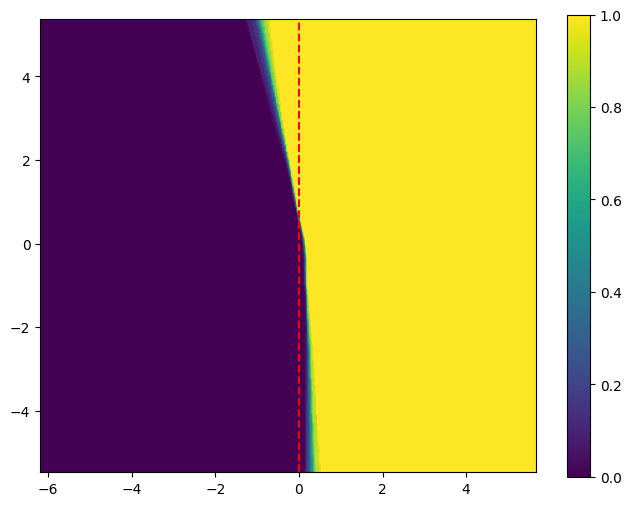

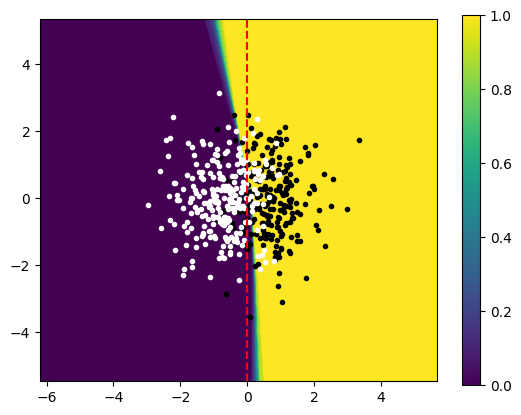

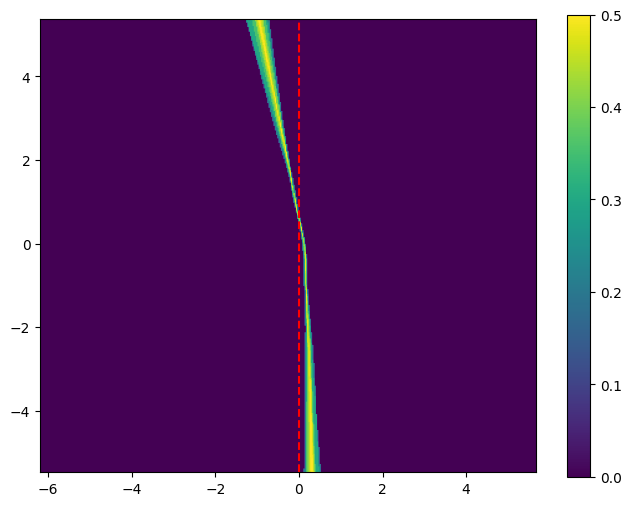

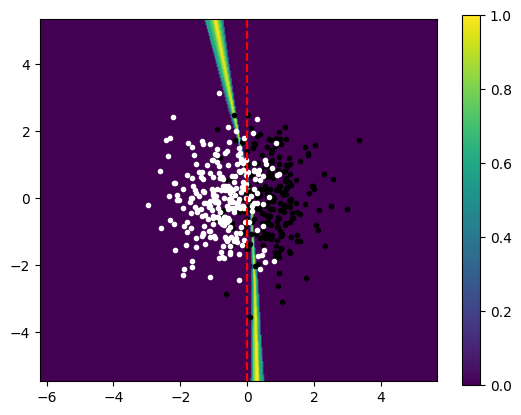

Train model 1/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate0.pkl
Train model 2/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate1.pkl
Train model 3/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate2.pkl
Train model 4/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate3.pkl
Train model 5/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate4.pkl
Train model 6/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate5.pkl
Train model 7/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate6.pkl
Train model 8/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate7.pkl
Train model 9/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate8.pkl
Train model 10/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate9.pkl
Train model 11/20
workspace/gaussian/tvae/prediction_task_mlp_n500_n_syn5000_aggregate10.

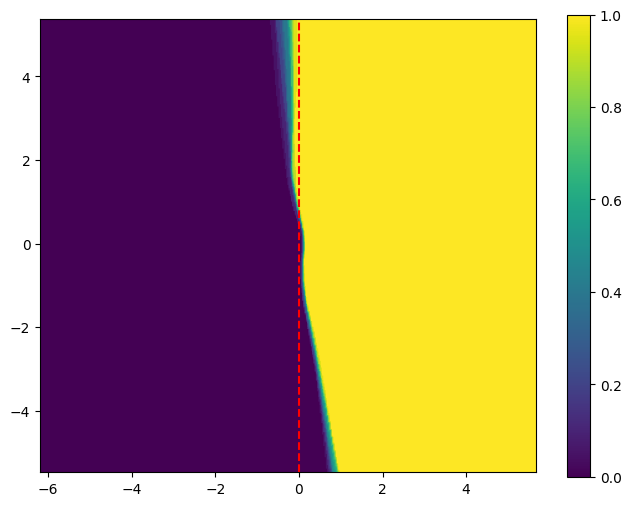

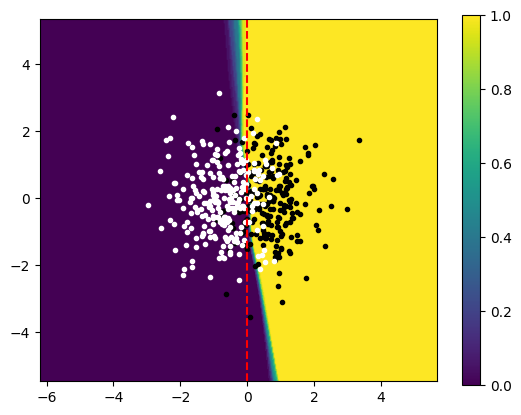

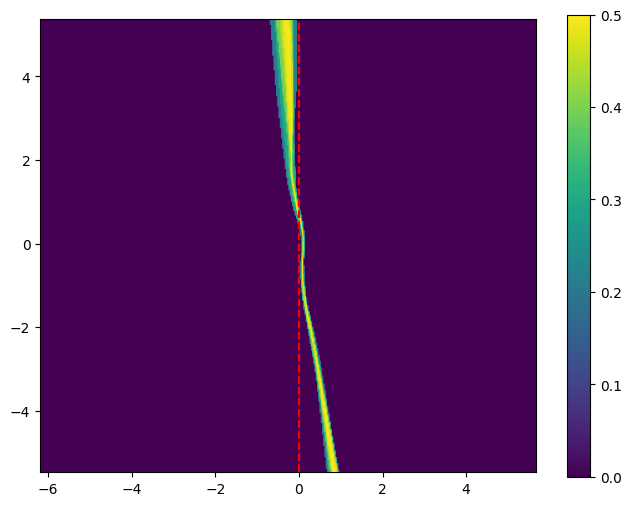

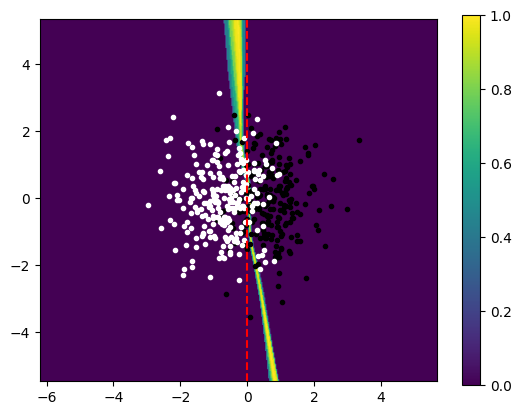

In [21]:
if X_gt.targettype=='classification':    
    for n_syn in n_syns:
        X_syn_cat = pd.concat([X_syns[i][:n_syn] for i in range(len(X_syns))], axis=0)
        X_syn_cat = GenericDataLoader(X_syn_cat, target_column="target")
        X_syn_cat = [X_syn_cat for _ in range(len(X_syns))]
        #X_syn_cat = [X_syn_cat.sample(len(X_syns[0])) for _ in range(len(X_syns))]
        
        y_pred_mean, y_pred_std, models = aggregate_imshow(X_gt, X_syn_cat, prediction_task, models=None, task_type='mlp', load=load, save=save, filename=f'n_syn{n_syn}_aggregate')
